# Preamble

This is an IPython Notebook to accompany the paper entitled 'The Architecture of Genome Wide Association Studies' by Melinda Mills and Charles Rahal. This allows us to share data analysis done in the construction of this data-driven review of all GWAS to date. It can also be used to dynamically replicate the analysis herein going forward. For installation guidelines, please see the readme.md which accompanies this repository. A preliminary point to note is that if you wish to run this .ipynb file itself, you *may* need to override the default settings of some versions of Jupyter Notebook (4.2 to 5.1) by opening with:

```
jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
```
or editing your jupyter_notebook_config.py file. Lets begin by loading in our favourite python modules, ipython magic and a bunch of custom functions we've written specifically for this project:

In [1]:
import networkx as nx
import os
import pandas as pd
import re
import seaborn as sns
import sys
import numpy as np
import csv
import itertools
import warnings
import gender_guesser.detector as gender
from Bio import Entrez
from IPython.display import HTML, display
from Support.LoadData import (
    EFO_parent_mapper,
    load_gwas_cat,
    load_pubmed_data, 
    make_timely,
    make_clean_CoR,
    download_cat
)
from Support.PubMed import (
    build_collective,
    build_author,
    build_funder,
    build_abstract,
    build_citation
)
from Support.Analysis import (
    simple_facts,
    ancestry_parser,
    make_meanfemale_andranks,
    make_funders,
    mapped_trait_summary
)
from Support.Figures import (
    gwas_growth,
    choropleth_map,
    wordcloud_figure,
    plot_heatmap,
    plot_bubbles,
    boxswarm_plot
)
from Support.Additional import clean_names
from Support.Ancestry import ancestry_cleaner

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'png'
%matplotlib inline
%load_ext autoreload
%autoreload 2

Then, let's dynamically grab the three main curated datasets from the GWAS Catalogue [EBI website](https://www.ebi.ac.uk) that we will need for our endeavours ('All Associations','All Studies', 'All Ancestries') and the EFO to Parent trait mapping file from their FTP site:

In [2]:
output_path = os.path.abspath(os.path.join('__file__',
                                    '../..',
                                    'data',
                                    'Catalogue',
                                    'Raw'))
ebi_download = 'https://www.ebi.ac.uk/gwas/api/search/downloads/'
download_cat(output_path, ebi_download)

Lets link the PUBMEDID variable to the PUBMED API and get a series of datasets from that using the support functions written in PubMed.py. Note: *collective* corresponds mostly consortia and study groups.

In [3]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
id_list = set(Cat_Studies['PUBMEDID'].astype(str).tolist())
Entrez.email = 'your@email.com'
papers = Entrez.read(Entrez.efetch(db='pubmed',retmode='xml', id=','.join(id_list)))
build_collective(papers)
build_author(papers)
build_funder(papers)
build_abstract(papers)
build_citation(id_list,Entrez.email)

Number of Collectives Found: 1546!
Authors with last names but no forenames: 7 out of 119948
Built a database of Authors from list of PUBMEDID IDs!
Built a database of Funders from list of PUBMEDID IDs!
Built a database of Abstracts from list of PUBMEDID IDs!


Processing for Citations: : 100%|████████████████████████████████████████████████| 3557/3557 [2:27:20<00:00,  2.49s/it]


# Introduction

## Some simple 'facts'

Lets do some basic descriptive analysis to see what we've got here:

In [4]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()
simple_facts(Cat_Studies, Cat_Ancestry,
             Cat_Ancestry_groupedbyN, Cat_Full,
             AuthorMaster, mostrecentgwascatdate='2018-08-29')

There are currently: 3557 GWAS papers published (in terms of unique PUBMEDIDs)
The first observed GWAS in the catalogue was dated: 2005-03-10
However, only: 10 papers were published in 2005 and 2006 combined
There are currently: 5678 unique Study Accessions
There are currently: 3397 unique Diseases/Traits studied
These correspond to: 2447 unique EBI "Mapped Traits"
The total number of Associations found is currently: 81947
The average number of Associations is currently: 14.4
Mean P-Value for the strongest SNP risk allele is currently: 1.4166e-06
The number of associations reaching the 5e-8 threshold is 43890
The journal to feature the most GWAS studies since 2005-03-10 is: Nat Genet
However, in 2017, Nat Commun published the largest number of GWAS papers
So far, in 2018, Nat Genet published the largest number of GWAS papers
Largest Accession to date: 808380.0 people.
This was published in Nat Commun.
The first author was: Helgadottir A.
Total number of SNP-trait associations is 81947.

## Can the abstracts give us any clues?

Lets make a nice infographic and do some basic NLP on the abstracts from all PUBMED IDs. This figure is the header on the readme.md:

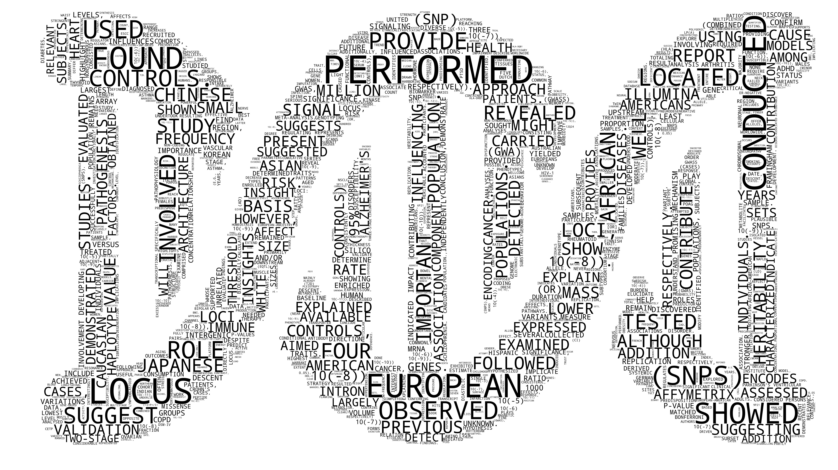

In [5]:
abstract_count = os.path.abspath(
                 os.path.join('__file__', '../..', 'data', 'PUBMED',
                              'Pubmed_AbstractCount.csv'))
output_file = os.path.abspath(
              os.path.join('__file__', '../../', 'figures', 'pdf',
                           'helix_wordcloud_1250_5000_black.pdf'))
wordcloud_figure(abstract_count, output_file)

The file Pubmed_AbstractCount in PUBMED (subdirectory of Data) details a breakdown of the abstract counts. Check counts for 'European', 'Asian', etc.

# The growth in depth and scope of GWAS over time

We can also visualise the ever increasing sample sizes and the popularity of GWAS. The top panel shows the increasing number of GWAS conducted over time. We also see increasingly large sample sizes: i.e. the fraction of 'Big N' sample size studies increases. The bottom left subplot shows that with this growth comes bigger N and a high correlatation with the number of significant Associations found. The right subplot shows the unique number of journals publishing GWAS per year and the unique number of diseases or traits studied. Both steadily increase as the appeal of GWASs broadens.

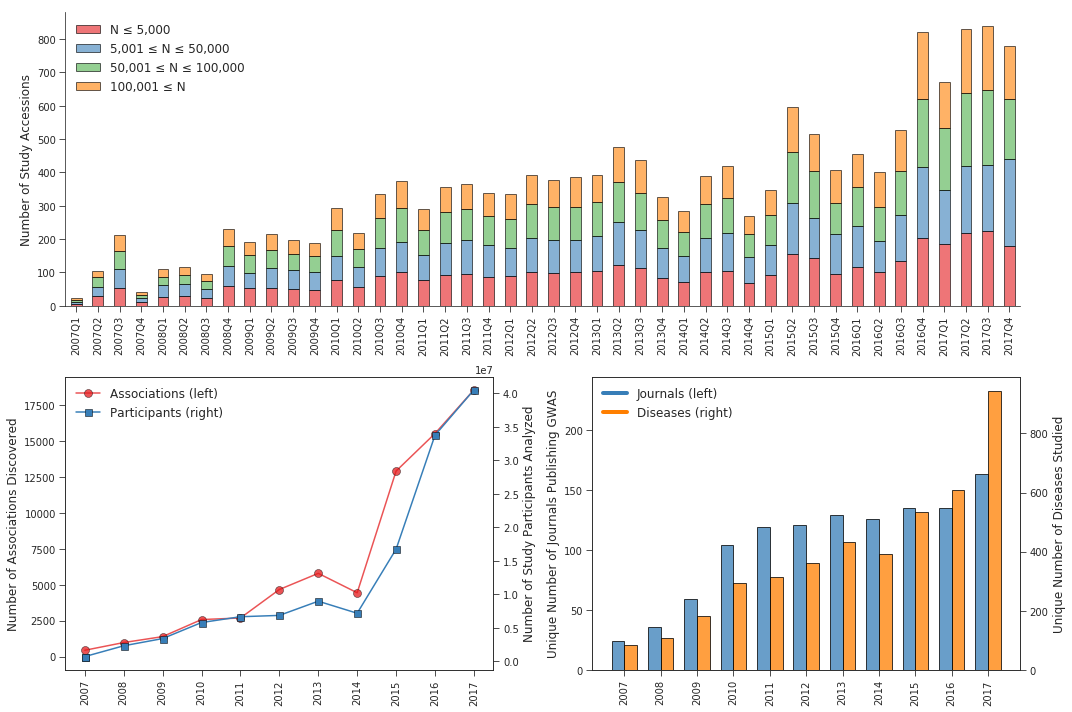

In [6]:
output_file = os.path.abspath(
              os.path.join('__file__', '../../', 'figures', 'svg',
                           'Figure_1.svg'))
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
gwas_growth(output_file, Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN)

#  Participants

## Ancestry

This section of analysis *only* uses data contained within the catalogue, but is slightly deeper than Section 2 above and other related papers in the literature. We use the 'Broad Ancestral Category' field and aggregate from 135 combinations of 17 ancestries to 7 'broader ancestral categories' to calculate a comparable measure to Popejoy and Fullerton. To get a more detailed analysis of polyvocality, we load in some of our supporting functions to clean up the "INITIAL SAMPLE SIZE" and "REPLICATION SAMPLE SIZE" free-text fields in the catalogue and then calculate something analogous to Panofsky and Bliss. The supporting functions are based on regular expression and data wrangling techniques which exploit patterns in the these free-text fields. By way of a very simple example: “19,546 British ancestry individuals from 6863 families.” will get cleaned to two seperate fields: “19,546” and “British” which can then be used for further downstream analysis. A slightly more complex example: “2,798 European ancestry individuals, 228 French Canadian founder population individuals” will correspond to two entries of 2798 and 228 in the new ‘Cleaned N’ type variable, corresponding to ‘European’ and ‘French Canadian’ in the ‘Cleaned Ancestry’ type variable respectively. Uncomment the appropriate lines of text to get the full lists.

In [7]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
Cat_Studies['InitialClean'] = Cat_Studies.apply(
    lambda row: ancestry_cleaner(row, 'INITIAL SAMPLE SIZE'), axis=1)
output_path = os.path.abspath(
              os.path.join('__file__',
                           '../..',
                           'data',
                           'Catalogue',
                           'Synthetic',
                           'new_initial_sample.csv'))
ancestry_parser(output_path, 'InitialClean', Cat_Studies)
Cat_Studies['ReplicationClean'] = Cat_Studies.apply(
    lambda row: ancestry_cleaner(row, 'REPLICATION SAMPLE SIZE'), axis=1)
output_path = os.path.abspath(
              os.path.join('__file__',
                           '../..',
                           'data',
                           'Catalogue',
                           'Synthetic',
                           'new_replication_sample.csv'))
ancestry_parser(output_path, 'ReplicationClean', Cat_Studies)

In [8]:
clean_intial = pd.read_csv(os.path.abspath(
                           os.path.join('__file__', '../..', 'data',
                                        'Catalogue', 'Synthetic',
                                        'new_initial_sample.csv')),
                           encoding='utf-8')
clean_initial_sum = pd.DataFrame(
    clean_intial.groupby(['Cleaned Ancestry']).sum())
clean_initial_sum.rename(
    columns={'Cleaned Ancestry Size': 'Initial Ancestry Sum', }, inplace=True)
clean_initial_count = clean_intial.groupby(['Cleaned Ancestry']).count()
clean_initial_count.rename(
    columns={'Cleaned Ancestry Size': 'Initial Ancestry Count', }, inplace=True)
clean_initial_merged = clean_initial_sum.merge(pd.DataFrame(
    clean_initial_count['Initial Ancestry Count']), how='outer', left_index=True,
    right_index=True)
clean_initial_merged = clean_initial_merged.sort_values(
    by='Initial Ancestry Sum', ascending=False)
holder = ''
for index, row in clean_initial_merged.iterrows():
    holder = holder + \
        str(index) + ' (' + str(row['Initial Ancestry Sum']) + \
        ',' + str(row['Initial Ancestry Count']) + '), '
print('There are a total of ' + str(len(clean_initial_merged)) +
      ' ancestries found in the \'INITIAL SAMPLE SIZE\' column.' +
      '\nThese are: (number of people used used in all studies, ' +
      'number of studies included):\n\n' + holder[:-2] + '.\n\n')

There are a total of 207 ancestries found in the 'INITIAL SAMPLE SIZE' column.
These are: (number of people used used in all studies, number of studies included):

European (86308821,5775), Japanese (6483362,582), British (3927349,50), Icelandic (2290333,20), African American (1621477,711), East Asian (1595237,203), Finnish (918380,157), African (670041,159), Korean (559893,241), Hispanic (538177,250), Han Chinese (537566,383), South Asian (496698,52), Hispanic/Latino (281971,62), Asian (281048,140), Chinese (274747,165), Indian Asian (181580,44), Latin American (162910,42), African American/Afro Caribbean (161018,36), Indian (127862,52), Hispanic/Latino American (116226,12), African American or Afro Caribbean (102828,10), Hispanic or Latino (83557,4), European and Asian (79845,2), Dutch (75049,20), Taiwanese Han Chinese (72100,14), Swedish (67990,23), Sardinian (66472,24), European American (63371,37), Filipino (61239,41), Northern European (59894,17), Latino (54928,41), Pomak (53847,

In [9]:
clean_replication = pd.read_csv(os.path.abspath(
                                os.path.join('__file__',
                                             '../..',
                                             'data',
                                             'Catalogue',
                                             'Synthetic',
                                             'new_replication_sample.csv')),
                                encoding='utf-8')
clean_replication_sum = pd.DataFrame(
    clean_replication.groupby(['Cleaned Ancestry']).sum())
clean_replication_sum.rename(
    columns={'Cleaned Ancestry Size': 'Replication Ancestry Sum', }, inplace=True)
clean_replication_count = clean_replication.groupby(
    ['Cleaned Ancestry']).count()
clean_replication_count.rename(
    columns={'Cleaned Ancestry Size': 'Replication Ancestry Count', }, inplace=True)
clean_replication_merged = clean_replication_sum.merge(
    pd.DataFrame(clean_replication_count['Replication Ancestry Count']),
    how='outer', left_index=True, right_index=True)
clean_replication_merged = clean_replication_merged.sort_values(
    by='Replication Ancestry Sum', ascending=False)
holder = ''
for index, row in clean_replication_merged.iterrows():
    holder = holder + \
        str(index) + ' (' + str(row['Replication Ancestry Sum']) + \
        ',' + str(row['Replication Ancestry Count']) + '), '
print('There are a total of ' + str(len(clean_replication_merged)) +
      ' ancestries found in the \'REPLICATION SAMPLE SIZE\' column.' +
      ' These are (number of people used used in all studies, number of' +
      ' studies included):\n\n' + holder[:-2] + '.')


There are a total of 148 ancestries found in the 'REPLICATION SAMPLE SIZE' column. These are (number of people used used in all studies, number of studies included):

European (36222204,3025), Asian (3387710,110), East Asian (2129170,237), Icelandic (1181163,17), Japanese (1059831,292), Han Chinese (1023973,254), African American (753265,350), Chinese (417161,181), Hispanic (397124,146), South Asian (394398,60), Korean (306162,146), British (251083,3), African (192176,76), European and Asian (136010,2), Indian Asian (118255,14), African American/Afro Caribbean (104015,48), European and African American (99227,9), European and East Asian (87155,5), Finnish (76236,23), Hispanic/Latino (62435,12), Indian (50713,47), Hispanic/Latino American (43200,6), European and Middle East/North African (29807,2), African America/Afro Caribbean (27661,1), Mexican (27148,17), Sardinian (25831,13), Latino (25299,17), Sub Saharan African (23752,26), European and  Rucphen (22789,1), Malay (22036,27), Brazi

Lets aggregate to create a dataframe for natives/indigenous people using a dictionary based classifier

In [10]:
native_dict = pd.read_csv(os.path.abspath(os.path.join('__file__', '../..',
                                         'data', 'Support',
                                         'native_classifier_dictionary.csv')),
                            index_col='Cleaned Ancestry')
native_df = pd.merge(clean_replication_merged, clean_initial_merged,
                   left_index=True,right_index=True, how='outer')
if len(np.setdiff1d(native_df.index.values, native_dict.index.values))>0:
    print('There are still ancestries which need classifying as unique!'+
         ' Add them to the dictionary: ' +
         ', '.join(np.setdiff1d(native_df.index.values,native_dict.index.values)))
else:
    print('Congratulations! The Native/Indigenous dictionary is fully up to date!')
native_df = native_df.fillna(0)
native_df['Total Ancestry Sum'] = native_df['Replication Ancestry Sum'] + \
                                  native_df['Initial Ancestry Sum']
native_df['Total Ancestry Count'] = native_df['Replication Ancestry Count'] + \
                                    native_df['Initial Ancestry Count']
native_df = pd.merge(native_df,native_dict,left_index=True, right_index=True)
print('We observe ' + str(len(native_df)) + ' unique terms for ancestry/ethnicity in total.')
print('Of these, ' + str(len(native_df[native_df['Native Population']!='Not Native'])) + 
      ' relate to native or Indigenous populations ancestry/ethnicity.')

Congratulations! The Native/Indigenous dictionary is fully up to date!
We observe 235 unique terms for ancestry/ethnicity in total.
Of these, 19 relate to native or Indigenous populations ancestry/ethnicity.


In [11]:
print('These relate to ' +
      str(len(native_df[native_df['NativeType']=='Indicated']['Native Population'].unique())) + 
      ' specific native/indigenous groups as implied by the free text.')
print('These are: '+
     ', '.join(native_df[native_df['NativeType']=='Indicated']['Native Population'].unique()))
print('Out of ' + str(int(native_df['Total Ancestry Count'].sum())) +
     ' mentions of ancestry\ethnicity, ' +
     str(int(native_df[native_df['NativeType']=='Indicated']['Total Ancestry Count'].sum())) + 
     ' relate to native/indigenous groups as implied by the free text.' +
     '('+
      str(round(native_df[native_df['NativeType']=='Indicated']['Total Ancestry Count'].sum()/
      native_df['Total Ancestry Count'].sum()*100,3)) +'%)')
print('Out of ' + str(int(native_df['Total Ancestry Sum'].sum())) +
     ' participants, ' +
     str(int(native_df[native_df['NativeType']=='Indicated']['Total Ancestry Sum'].sum())) + 
     ' are of native/indigenous groups as implied by the free text.'  +
     '('+
      str(round(native_df[native_df['NativeType']=='Indicated']['Total Ancestry Sum'].sum()/
      native_df['Total Ancestry Sum'].sum()*100,3)) +'%)')
print('Most commonly used natives implied by the free text is: ' +
     native_df[native_df['NativeType']=='Indicated']['Total Ancestry Sum'].sort_values(ascending=False).index.values[0] +
     ' which contributed ' + 
      str(int(native_df[native_df['NativeType']=='Indicated']['Total Ancestry Sum'].sort_values(ascending=False)[0]))+
     ' people in terms of sample.')

These relate to 8 specific native/indigenous groups as implied by the free text.
These are: Aboriginal Canadians, Hispanic/Native American, Indigenous Mexicans, Indigenous Australian, Native Americans, Indigenous peoples of South America, Native Americans or Alaska Natives, Native Hawaiians
Out of 16105 mentions of ancestry\ethnicity, 34 relate to native/indigenous groups as implied by the free text.(0.211%)
Out of 158738617 participants, 9353 are of native/indigenous groups as implied by the free text.(0.006%)
Most commonly used natives implied by the free text is: Native Hawaiian which contributed 3179 people in terms of sample.


In [12]:
print('These relate to ' +
      str(len(native_df[native_df['NativeType']!='Not Native']['Native Population'].unique())) + 
      ' specific native/indigenous implied by the free text or which are manually classified.')
print('These are: '+
     ', '.join(native_df[native_df['NativeType']!='Not Native']['Native Population'].unique()))
print('Out of ' + str(int(native_df['Total Ancestry Count'].sum())) +
     ' mentions of ancestry\ethnicity, ' +
     str(int(native_df[native_df['NativeType']!='Not Native']['Total Ancestry Count'].sum())) + 
     ' relate to native/indigenous populations implied by the free text or which are manually classified.' +
     '('+
      str(round(native_df[native_df['NativeType']!='Not Native']['Total Ancestry Count'].sum()/
      native_df['Total Ancestry Count'].sum()*100,3)) +'%)')
print('Out of ' + str(int(native_df['Total Ancestry Sum'].sum())) +
     ' participants, ' +
     str(int(native_df[native_df['NativeType']!='Not Native']['Total Ancestry Sum'].sum())) + 
     ' are of native/indigenous populations implied by the free text or which are manually classified.' +
     '('+
      str(round(native_df[native_df['NativeType']!='Not Native']['Total Ancestry Sum'].sum()/
      native_df['Total Ancestry Sum'].sum()*100,3)) +'%)')
print('Most commonly used natives implied by the free text or which are manually classified is: ' +
     native_df[native_df['NativeType']!='Not Native']['Total Ancestry Sum'].sort_values(ascending=False).index.values[0] +
     ' which contributed ' + 
      str(int(native_df[native_df['NativeType']!='Not Native']['Total Ancestry Sum'].sort_values(ascending=False)[0]))+
     ' people in terms of sample.')

These relate to 16 specific native/indigenous implied by the free text or which are manually classified.
These are: Aboriginal Canadians, Native American, Pacific Islander, Bashkirs, Saami, Hispanic/Native American, Indigenous Mexicans, Indigenous Australian, Mayan, Native Americans, Indigenous peoples of South America, Native Americans or Alaska Natives, Native Hawaiians, Pima Indians, Plains Indians, Samoan
Out of 16105 mentions of ancestry\ethnicity, 81 relate to native/indigenous populations implied by the free text or which are manually classified.(0.503%)
Out of 158738617 participants, 37528 are of native/indigenous populations implied by the free text or which are manually classified.(0.024%)
Most commonly used natives implied by the free text or which are manually classified is: Pima Indian which contributed 10746 people in terms of sample.


Lets first now do a quick check that our 'Broader' dictionary is up to date:

In [13]:
if len(Cat_Ancestry[Cat_Ancestry['Broader'].isnull()]) > 0:
    print('Perhaps we need to update the dictionary for new terms? Something like these ones:\n' +
         '\n'.join(Cat_Ancestry[Cat_Ancestry['Broader'].isnull()]['BROAD ANCESTRAL'].unique()))
else:
    print('Nice! Looks like our Broad to Broader dictionary is up to date!')

Nice! Looks like our Broad to Broader dictionary is up to date!


Lets put this number into tables to get a deeper understanding, first including a row which has at least one ancestry as NR, and then dropping all rows in which at least one recorded ancestry is NR:

In [14]:
Broad_Ancestral_Full_initial = pd.DataFrame(
    Cat_Ancestry[Cat_Ancestry.STAGE ==
                 'initial'].groupby(['Broader'])['N'].sum())
Broad_Ancestral_Full_initial.rename(
    columns={'N': 'N (Initial)'}, inplace=True)
Broad_Ancestral_Full_replication = pd.DataFrame(
    Cat_Ancestry[Cat_Ancestry.STAGE ==
                 'replication'].groupby(['Broader'])['N'].sum())
Broad_Ancestral_Full_replication.rename(
    columns={'N': 'N (Replication)'}, inplace=True)
Broad_Ancestral_Full = pd.merge(Broad_Ancestral_Full_initial,
                                Broad_Ancestral_Full_replication,
                                left_index=True, right_index=True)
Broad_Ancestral_Full['Total'] = Broad_Ancestral_Full['N (Initial)'] + \
    Broad_Ancestral_Full['N (Replication)']
Broad_Ancestral_Full['% Discovery'] = (
    Broad_Ancestral_Full['N (Initial)'] /
    Broad_Ancestral_Full['N (Initial)'].sum()) * 100
Broad_Ancestral_Full['% Replication'] = (
    Broad_Ancestral_Full['N (Replication)'] /
    Broad_Ancestral_Full['N (Replication)'].sum()) * 100
Broad_Ancestral_Full['% Total'] = (Broad_Ancestral_Full['Total'] /
                                   Broad_Ancestral_Full['Total'].sum()) * 100
Broad_Ancestral_Full.to_csv(os.path.abspath(
                            os.path.join('__file__',
                                         '../..',
                                         'tables',
                                         'Broad_Ancestral_Full.csv')))
Broad_Ancestral_Full

N (Initial)  N (Replication)      Total  % Discovery  \
Broader                                                                         
African                       361817           136576     498393     0.307131   
African Am./Caribbean        2258708          1015713    3274421     1.917324   
Asian                       11018150          9013536   20031686     9.352851   
European                    94342989         37652655  131995644    80.083851   
Hispanic/Latin American      1502967           665219    2168186     1.275806   
In Part Not Recorded         7762814          5022605   12785419     6.589531   
Other/Mixed                   557815           856988    1414803     0.473506   

                         % Replication    % Total  
Broader                                            
African                       0.251228   0.289480  
African Am./Caribbean         1.868380   1.901869  
Asian                        16.580188  11.634927  
European                     69.261175  76.666524  
Hispanic/Latin American       1.223655   1.259339  
In Part Not Recorded          9.238964   7.426106  
Other/Mixed                   1.576409   0.821755

Drop the 'in part not recorded' rows (i.e. where the Broad Ancestral Category contains at least one NR):

In [15]:
Broad_Ancestral_NoNR = Broad_Ancestral_Full[['N (Initial)',
                                             'N (Replication)',
                                             'Total']]
Broad_Ancestral_NoNR = Broad_Ancestral_NoNR.drop('In Part Not Recorded')
Broad_Ancestral_NoNR['Total'] = Broad_Ancestral_NoNR['N (Initial)'] + \
    Broad_Ancestral_NoNR['N (Replication)']
Broad_Ancestral_NoNR['% Discovery'] = (
    Broad_Ancestral_NoNR['N (Initial)'] /
    Broad_Ancestral_NoNR['N (Initial)'].sum()) * 100
Broad_Ancestral_NoNR['% Replication'] = (
    Broad_Ancestral_NoNR['N (Replication)'] /
    Broad_Ancestral_NoNR['N (Replication)'].sum()) * 100
Broad_Ancestral_NoNR['% Total'] = (Broad_Ancestral_NoNR['Total'] /
                                   Broad_Ancestral_NoNR['Total'].sum()) * 100
Broad_Ancestral_NoNR.to_csv(os.path.abspath(
                            os.path.join('__file__', '../..', 'tables',
                                         'Broad_Ancestral_NoNR.csv')))
Broad_Ancestral_NoNR

N (Initial)  N (Replication)      Total  % Discovery  \
Broader                                                                         
African                       361817           136576     498393     0.328798   
African Am./Caribbean        2258708          1015713    3274421     2.052579   
Asian                       11018150          9013536   20031686    10.012636   
European                    94342989         37652655  131995644    85.733272   
Hispanic/Latin American      1502967           665219    2168186     1.365807   
Other/Mixed                   557815           856988    1414803     0.506909   

                         % Replication    % Total  
Broader                                            
African                       0.276802   0.312701  
African Am./Caribbean         2.058571   2.054434  
Asian                        18.267958  12.568260  
European                     76.311574  82.816570  
Hispanic/Latin American       1.348216   1.360361  
Other/Mixed                   1.736879   0.887674

What are the broad ancestral fields before we visualise the broader field? Dropping all rows for multiple (comma separated entries):

Lets now make some bubble plots to visualise the raw broad ancestry field and our fields extracted from the free text strings:

In [16]:

GroupAnc = Cat_Ancestry[(Cat_Ancestry['BROAD ANCESTRAL'] != 'Other') &
                        (Cat_Ancestry['BROAD ANCESTRAL'].str.count(',') == 0)].\
    groupby(['BROAD ANCESTRAL'])['N'].sum().to_frame()
GroupAnc['Individuals (%)'] = (GroupAnc['N'] /
                               GroupAnc['N'].sum()) * 100
GroupAnc.sort_values(by='Individuals (%)',ascending=False)[0:10]

N  Individuals (%)
BROAD ANCESTRAL                                               
European                            131995644        78.398921
East Asian                           16041195         9.527681
NR                                   10565256         6.275242
African American or Afro-Caribbean    3274421         1.944845
Hispanic or Latin American            2168186         1.287796
Asian unspecified                     2027497         1.204234
South Asian                           1674794         0.994745
African unspecified                    333154         0.197877
South East Asian                       116675         0.069299
Sub-Saharan African                    104798         0.062245

Now lets visualise the occurances of the 'Broader' ancestry conversion:

The biggest accession is 586626


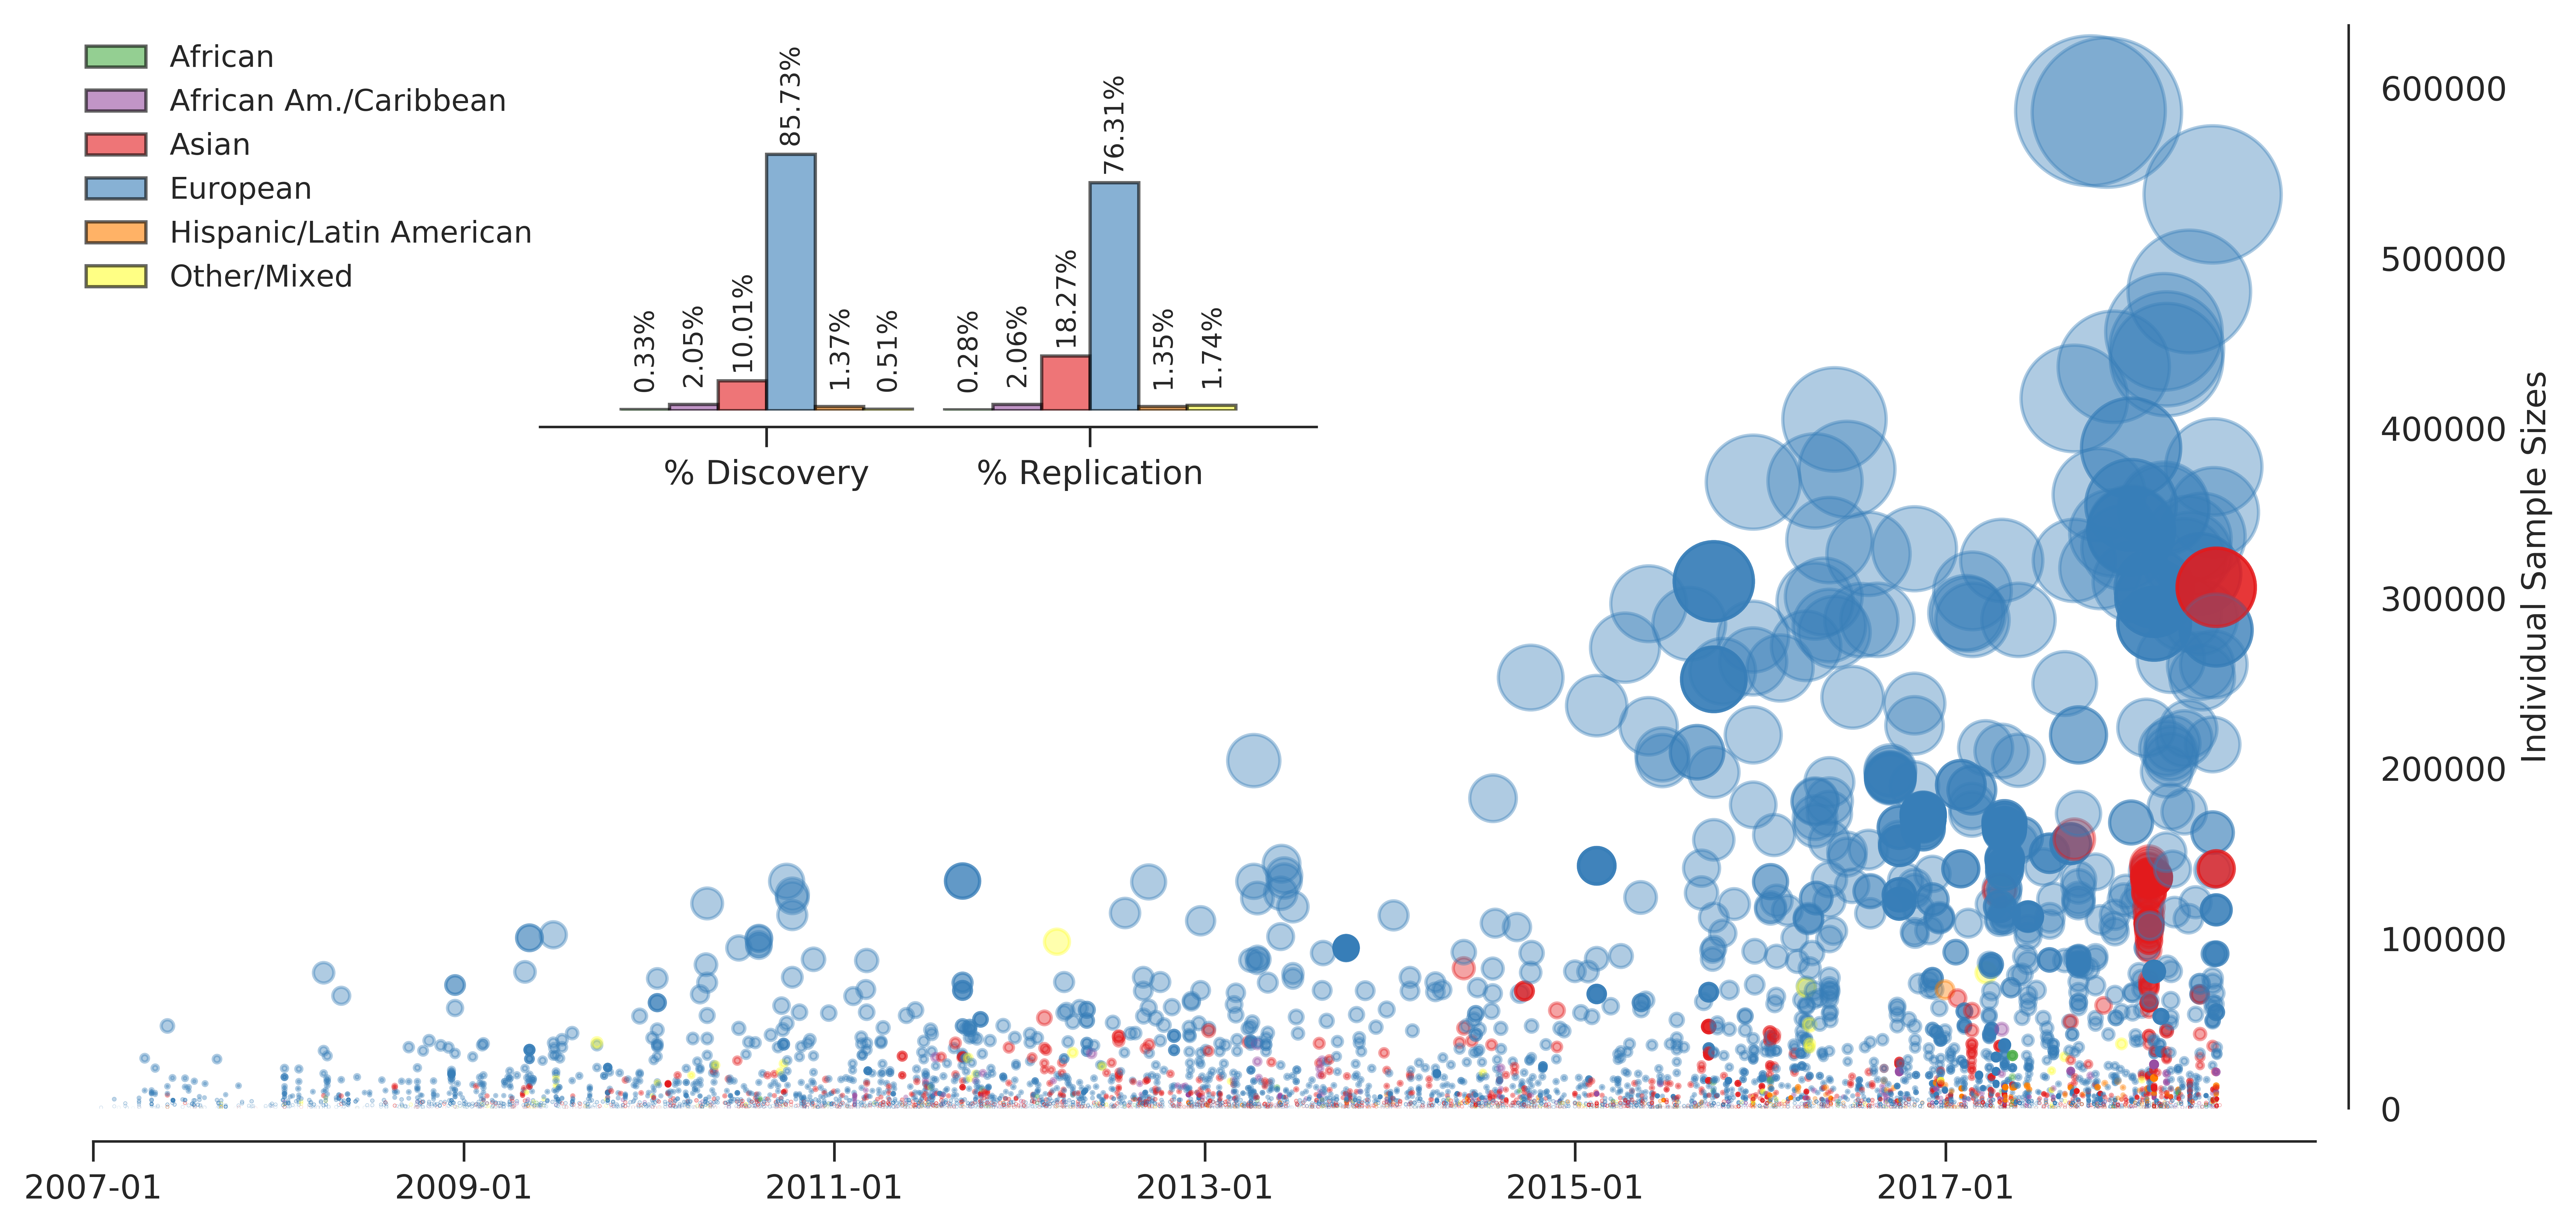

In [17]:
countriesdict = {'African': '#4daf4a', 'African Am./Caribbean': '#984ea3',
                 'Asian': '#e41a1c', 'European': '#377eb8',
                 'Hispanic/Latin American': '#ff7f00', 'Other/Mixed': '#ffff33'}
output_path = os.path.abspath(os.path.join('__file__', "../..", "figures", "svg",
                                             "Figure_2.svg"))
plot_bubbles(output_path, Cat_Ancestry, Broad_Ancestral_NoNR, countriesdict)
print('The biggest accession is ' + str(Cat_Ancestry['N'].max()))

We can also analyze how these aggregates change over time, and this was a key feature of [Popejoy and Fullerton (2016)](https://www.nature.com/news/genomics-is-failing-on-diversity-1.20759). We can provide a much more granular arguement (merely remove '_NoNR' from the cell below to undertake an equivlent analysis with rows which contain some in part NR ancestries):

In [18]:
index = [x for x in range(2007, 2019)]
columns = ['European', 'Asian', 'African', 'Hispanic/Latin American',
           'Other/Mixed', 'African Am./Caribbean']
Cat_Ancestry_NoNR = Cat_Ancestry[
    Cat_Ancestry['Broader'] != 'In Part Not Recorded']
Broad_Ancestral_Time_NoNR_PC = pd.DataFrame(index=index, columns=columns)
for year in range(2007, 2019):
    for broaderancestry in Broad_Ancestral_NoNR.index.tolist():
        Broad_Ancestral_Time_NoNR_PC[broaderancestry.strip()][year] =\
            (Cat_Ancestry_NoNR[(
                Cat_Ancestry_NoNR['DATE'].str.contains(str(year))) &
                (Cat_Ancestry_NoNR['Broader'] ==
                 broaderancestry)]['N'].sum() /
             Cat_Ancestry_NoNR[
             (Cat_Ancestry_NoNR['DATE'].str.contains(
                 str(year)))]['N'].sum()) * 100
Broad_Ancestral_Time_NoNR_PC.to_csv(os.path.abspath(
                            os.path.join('__file__', '../..', 'tables',
                                         'Broad_Ancestral_Time_NoNR_PC.csv')))
Broad_Ancestral_Time_NoNR_PC.head(12)

European    Asian     African Hispanic/Latin American Other/Mixed  \
2007  95.4688  2.13984  0.00542792                0.715245     1.18391   
2008  95.2884  2.94597           0              0.00180063     1.21894   
2009  88.1708  7.10488    0.258137                0.224117     3.36046   
2010  86.6601    10.04    0.270719               0.0591476     2.47158   
2011  78.2316  15.8233     0.15679                0.397565     1.70889   
2012  71.9735  19.4701    0.313032                0.884615     2.87484   
2013  82.1979  11.6865    0.394273                0.787581    0.617715   
2014  76.6056  18.6152    0.250182                 1.15204     0.97794   
2015  88.0646  9.11528    0.280238                0.738889    0.510574   
2016  90.5885  4.75047    0.171282                 1.49728     1.12096   
2017  88.1227   6.2475    0.569588                 2.29738    0.661675   
2018  70.5509   26.003    0.256689                 1.42186    0.105128   

     African Am./Caribbean  
2007              0.486807  
2008              0.544872  
2009              0.881605  
2010               0.49843  
2011               3.68185  
2012                4.4839  
2013               4.31598  
2014               2.39904  
2015               1.29045  
2016               1.87149  
2017               2.10111  
2018                1.6624

We can focus on the initial discovery stage to calculate the number of individuals required per ancestry to unconver one hit. Note however that this does require some distributional assumptions (i.e. that the same diseases are being studied across ancestries).

In [19]:
Cat_Ancestry_Initial = Cat_Ancestry[Cat_Ancestry['STAGE'] == 'initial']

Cat_Ancestry_NoDups = Cat_Ancestry_Initial.drop_duplicates(
    subset=['STUDY ACCESSION'],
    keep=False)[['PUBMEDID', 'STUDY ACCESSION',
                 'BROAD ANCESTRAL',
                 'N']]
Cat_Ancestry_NoDups_merge = pd.merge(Cat_Ancestry_NoDups,
                                     Cat_Studies[['ASSOCIATION COUNT',
                                                  'STUDY ACCESSION',
                                                  'MAPPED_TRAIT']],
                                     how='left', on='STUDY ACCESSION')

listtoiterate = ['European', 'East Asian', 'South Asian',
                 'African Am.\Caribbean', 'Hispanic\Latin American']
for ancestry in listtoiterate:
    temp = Cat_Ancestry_NoDups_merge[Cat_Ancestry_NoDups_merge[
        'BROAD ANCESTRAL'].str.strip() == ancestry]
    print('The number of ' + ancestry + 's required to find one hit: ' +
          str(round(1 /
                    (temp['ASSOCIATION COUNT'].sum() / temp['N'].sum()), 1)))


The number of Europeans required to find one hit: 1558.8
The number of East Asians required to find one hit: 1402.7
The number of South Asians required to find one hit: 572.0
The number of African Am.\Caribbeans required to find one hit: nan
The number of Hispanic\Latin Americans required to find one hit: nan


## Choropleth map of country of recruitment

This is a choropleth map of country of recruitment - note that this field is not quite fully populated in the Catalogue. Basemap code is loosely based on [this](http://ramiro.org/notebook/basemap-choropleth/). As we want to study the number of people recruited from each country, we can only utilize values in the ‘Country of Recruitment’ field when only one country is mentioned. For example: if N=100,000 and Country of Recruitment = {U.K., U.S.}, there is no way for us to know what the breakdown between the two countries is in the Catalogue (especially as the free text field may just contain 'European' ancestry). Our only option in this scenario is to drop such observations. This forces us to drop about 22% of all the studies, and this corresponds to about 48% of the Catalogue as measured by N (because bigger studies have multiple countries of recruitment). We are faced with multiple entries equal to ‘NR’, which corresponds to ‘not recorded’. This reduces the number of studies to go into the map by a further 21% (of the initial total), and this means that the map only includes about half of all GWAS studies. This has no relationship to whether ancestry is coded.

In [20]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
Clean_CoR = make_clean_CoR(Cat_Ancestry)
Cleaned_CoR_N = pd.DataFrame(Clean_CoR.groupby(['Cleaned Country'])['N'].sum())
Cleaned_CoR_N['Rank_N'] = Cleaned_CoR_N.rank(
    ascending=False, method='dense').astype(int)
Cleaned_CoR_count = pd.DataFrame(
    Clean_CoR.groupby(['Cleaned Country'])['N'].count())
Cleaned_CoR_count['Rank_count'] = Cleaned_CoR_count.rank(
    ascending=False, method='dense').astype(int)
Cleaned_CoR_count = Cleaned_CoR_count.rename(columns={'N': 'Count'})
Cleaned_CoR = pd.merge(Cleaned_CoR_count, Cleaned_CoR_N,
                       left_index=True, right_index=True)
del Cleaned_CoR.index.name
Cleaned_CoR['Count (%)'] = round((Cleaned_CoR['Count'] /
                                   Cleaned_CoR['Count'].sum()) * 100,2)
Cleaned_CoR['N (%)'] = round((Cleaned_CoR['N'] /
                               Cleaned_CoR['N'].sum()) * 100,2)
countrylookup = pd.read_csv(os.path.abspath(
                            os.path.join('__file__',
                                         '../..',
                                         'data',
                                         'ShapeFiles',
                                         'Country_Lookup.csv')),
                            index_col='Country')
country_merged = pd.merge(countrylookup,
                          Cleaned_CoR,
                          left_index=True,
                          right_index=True)
country_merged['Per Rec'] = round(country_merged['N']/pd.to_numeric(country_merged['2017population']),2)
country_merged.sort_values('Rank_N', ascending=True)[
    ['Continent', 'Count', 'N', 'Count (%)', 'N (%)', 'Per Rec']].to_csv(
    os.path.abspath(os.path.join('__file__',
                                 '../..',
                                 'tables',
                                 'CountryOfRecruitment.csv')))
country_merged.sort_values('Rank_N', ascending=True)[
    ['Continent', 'Count', 'N', 'Count (%)', 'N (%)', 'Per Rec']].head(10)

Cleaning for single country of recruitment: 72.342%  obs remain. 
This represents about 55.283% of the total GWAS N. 
When we drop for country==NR, we lose another: 24.62% papers.
6108 obs for this field remain out of a total of 11201 rows of Cat_Anc data


Continent  Count         N  Count (%)  N (%)  Per Rec
United Kingdom         Europe    653  21294574      10.69  40.00     0.32
United States   North America   2548  10549181      41.72  19.82     0.03
Japan                    Asia    460   7456048       7.53  14.01     0.06
Iceland                Europe     71   6409109       1.16  12.04    19.13
China                    Asia    478   2034701       7.83   3.82     0.00
Finland                Europe    208   1176077       3.41   2.21     0.21
Korea, South             Asia    252    840876       4.13   1.58     0.02
Netherlands            Europe    175    663477       2.87   1.25     0.04
Germany                Europe    170    417234       2.78   0.78     0.01
Australia             Oceania    108    319142       1.77   0.60     0.01

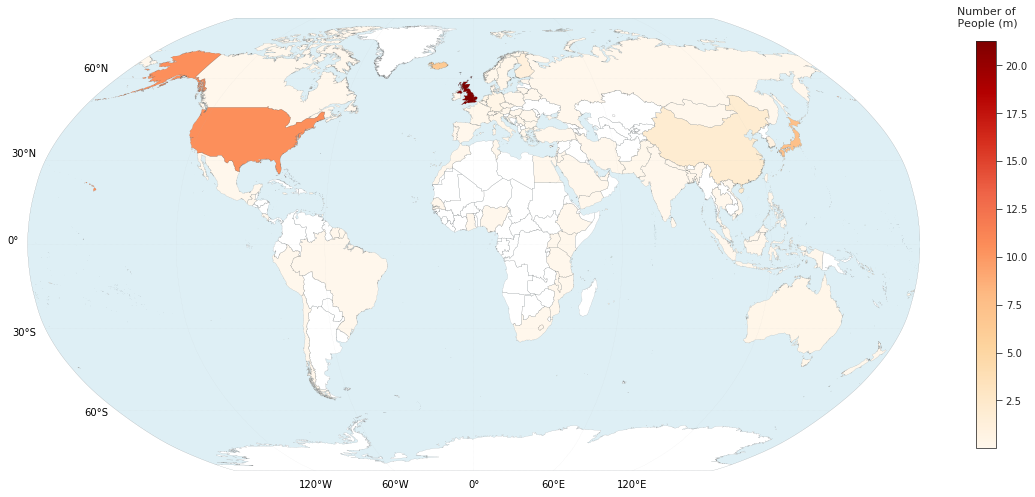

In [21]:
output_path = os.path.abspath(os.path.join('__file__',
                                           '../..',
                                           'figures',
                                           'svg',
                                           'Figure_3.svg'))
choropleth_map(country_merged, 'N', 'OrRd', output_path)

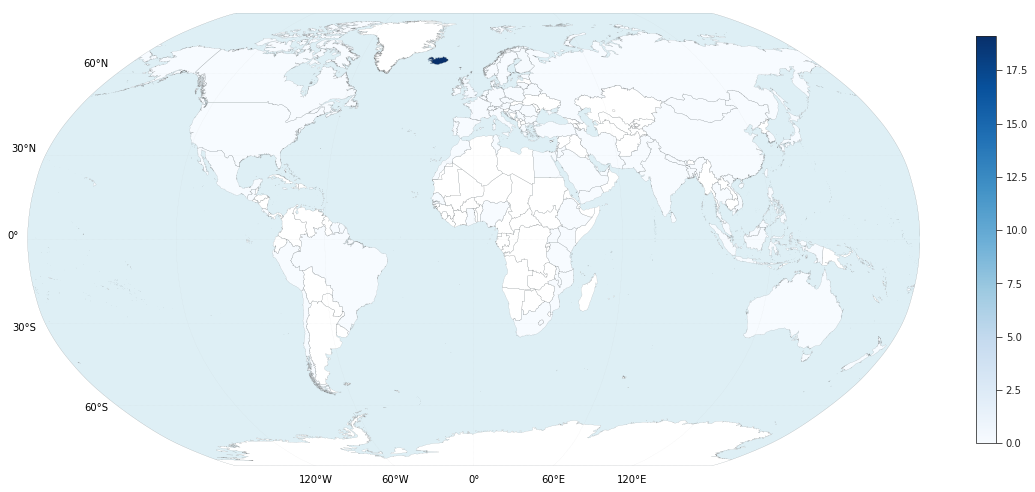

In [22]:
output_path = os.path.abspath(os.path.join('__file__',
                                           '../..',
                                           'figures',
                                           'svg',
                                           'Figure_3_Blues.svg'))
choropleth_map(country_merged, 'Per Rec', 'Blues', output_path)

Lets now merge that via a country lookup to continent based file using data from within the shapefile itself (based on CIAWF).

In [23]:
country_merged_sumcount = country_merged[[
    'Continent', 'Count']].groupby(['Continent']).sum()
country_merged_sumN = country_merged[[
    'Continent', 'N']].groupby(['Continent']).sum()
country_merged_sums = pd.merge(
    country_merged_sumN, country_merged_sumcount,
    left_index=True, right_index=True)
country_merged_sums['N (%)'] = (
    country_merged_sums['N'] / country_merged_sums['N'].sum()) * 100
country_merged_sums['Count (%)'] = (
    country_merged_sums['Count'] / country_merged_sums['Count'].sum()) * 100
country_merged_sums.to_csv(os.path.abspath(
                           os.path.join('__file__',
                                        '../..',
                                        'tables',
                                        'ContinentOfRecruitment.csv')))
country_merged_sums

N  Count      N (%)  Count (%)
Continent                                                     
Africa                      61021     59   0.114633   0.965946
Asia                     10952637   1498  20.575425  24.525213
Europe                   31192652   1762  58.597949  28.847413
North America            10667907   2642  20.040536  43.254748
Oceania                    331082    117   0.621965   1.915521
Seven seas (open ocean)      1389      1   0.002609   0.016372
South America               24957     29   0.046884   0.474787

# Who funds GWAS and what do they fund?

## A simple descriptive tabulation

Lets do a super simple tabulation of the Top 20 GWAS funders (measured by 'GWAS contributions': i.e. a funder funding an authors time on a paper).

In [24]:
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()
AllFunders = FunderInfo.groupby(by='Agency').count()
AllFunders.index.name = None
AllFunders = AllFunders.reset_index()
AllFunders = AllFunders.rename(columns={
                               'index': 'Agency',
                               'PUBMEDID': 'Grant Contributions',
                               'GrantCountry': 'Country'})
AllFunders_withcountries = pd.merge(AllFunders[['Agency',
                                                'Grant Contributions']],
                                    FunderInfo[['Agency',
                                                'GrantCountry']].drop_duplicates(
                                        'Agency'),
                                    on='Agency', how='left')
AllFunders_withcountries = AllFunders_withcountries.set_index('Agency')
AllFunders_withcountries.index.name = None
AllFunders_withcountries['% of Total'] = round((
    AllFunders_withcountries['Grant Contributions'] /
    AllFunders_withcountries['Grant Contributions'].sum()) * 100, 2)
AllFunders_withcountries.sort_values(
    'Grant Contributions', ascending=False)[0:20]

Grant Contributions    GrantCountry  % of Total
NHLBI NIH HHS                     12485   United States       25.84
NCI NIH HHS                        5151   United States       10.66
NIA NIH HHS                        4032   United States        8.34
MRC                                3497  United Kingdom        7.24
NIDDK NIH HHS                      2675   United States        5.54
NIMH NIH HHS                       2656   United States        5.50
Wellcome Trust                     1801  United Kingdom        3.73
NHGRI NIH HHS                      1789   United States        3.70
NCRR NIH HHS                       1556   United States        3.22
NIAID NIH HHS                      1190   United States        2.46
PHS HHS                            1141   United States        2.36
NIAMS NIH HHS                      1059   United States        2.19
NIAAA NIH HHS                       903   United States        1.87
NINDS NIH HHS                       749   United States        1.55
WHI NIH HHS                         743   United States        1.54
NIDA NIH HHS                        696   United States        1.44
NCATS NIH HHS                       683   United States        1.41
Cancer Research UK                  603  United Kingdom        1.25
NIGMS NIH HHS                       596   United States        1.23
Intramural NIH HHS                  585   United States        1.21

Lets print out some simple descriptives from this data:

In [25]:
print('There are ' + str(len(FunderInfo['Agency'].drop_duplicates())) +
      ' unique funders returned from PubMed Central.')
print('There are ' + str(len(FunderInfo['GrantID'].drop_duplicates())) +
      ' unique grants returned from PubMed Central.')
print('There are ' + str(len(FunderInfo['GrantCountry'].drop_duplicates())) +
      ' unique grant countries returned from PubMed Central.')
print('Each study has an average of ' +
      str(round(len(FunderInfo) / len(id_list), 2)) + ' grants funding it.')
grantgroupby = FunderInfo.groupby(['Agency', 'GrantID']).size().groupby(
    level=1).max().sort_values(ascending=False).reset_index()
print('The most frequently acknowledged grant is GrantID ' +
      grantgroupby['GrantID'][0] + '.\nThis grant is acknowledged ' +
      str(grantgroupby[0][0]) + ' times.')

There are 98 unique funders returned from PubMed Central.
There are 12656 unique grants returned from PubMed Central.
There are 7 unique grant countries returned from PubMed Central.
Each study has an average of 13.59 grants funding it.
The most frequently acknowledged grant is GrantID P30 DK063491.
This grant is acknowledged 205 times.


## International distribution of funders

From which countries do these grants come from?

In [26]:
TopCountryFunders = FunderInfo.groupby(by='GrantCountry').count()
TopCountryFunders = TopCountryFunders.rename(
    columns={'PUBMEDID': 'Number Of Studies'})
TopCountryFunders = TopCountryFunders.sort_values(
    'Number Of Studies', ascending=False)[['Number Of Studies']]
TopCountryFunders = TopCountryFunders.reset_index().rename(
    columns={'GrantCountry': 'Country of Funder'})
TopCountryFunders['Percent Funded (%)'] = (
    TopCountryFunders['Number Of Studies'] /
    TopCountryFunders['Number Of Studies'].sum()) * 100
TopCountryFunders = TopCountryFunders.set_index('Country of Funder')
TopCountryFunders.index.name = None
TopCountryFunders.head(10)

Number Of Studies  Percent Funded (%)
United States               41101           85.119911
United Kingdom               6934           14.360270
Canada                        175            0.362424
International                  64            0.132544
Austria                         7            0.014497
Italy                           5            0.010355

## What about the commas?

Lets first get a metric about splitting on the commas in the EFO field. We can make identical heatmaps by just replacing ```EFO_Parent_Mapped``` with ```EFO_Parent_Mapped_NoCommas```. This is inherently making the assumption that a GWAS which has two mentioned EFO contributes equally to each of them: as much as a GWAS with one EFO (i.e. no comma to split on) contributes to that one specific EFO.

In [27]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
EFO_Parent_Mapped, EFO_Parent_Mapped_NoCommas = EFO_parent_mapper(
    Cat_Studies, Cat_Ancestry_groupedbyN)
print('There are ' + str(len(EFO_Parent_Mapped)) +
      ' rows of EFO terms after we split for commas.')
print('This indicates ' + str(len(EFO_Parent_Mapped) -\
                              len(EFO_Parent_Mapped_NoCommas)) +
      ' additional terms were mapped than for when we drop csvs.')
print('This indicates ' +
      str(len(EFO_Parent_Mapped['EFO term'].drop_duplicates())) +
      ' unique EFO terms to map to Parents.')
print('This is in comparison to ' +
      str(len(EFO_Parent_Mapped_NoCommas['EFO term'].drop_duplicates())) +
      ' unique EFO terms in Cat_Studies.')

There are 7830 rows of EFO terms after we split for commas.
This indicates 3579 additional terms were mapped than for when we drop csvs.
This indicates 1928 unique EFO terms to map to Parents.
This is in comparison to 1354 unique EFO terms in Cat_Studies.


## What do they study?


In [28]:
mapped_trait_summary(EFO_Parent_Mapped, 'EFO term')
mapped_trait_summary(EFO_Parent_Mapped_NoCommas,'EFO term')

                             Sample   Studies  Associations
EFO term                                                   
Type II Diabetes Mellitus  1.731211  1.240885      0.701573
Body Mass Index            3.741513  1.202507      2.756953
Schizophrenia              0.913502  1.087374      1.169689
Breast Carcinoma           0.976628  0.985033      0.769564
Bipolar Disorder           0.365675  0.972240      0.339354
Unipolar Depression        2.541905  0.946655      0.453676
Alzheimers Disease         0.672238  0.946655      0.482557
HD LC measurement          0.799611  0.882692      1.128172
Triglyceride Meas.         0.779878  0.754765      1.074020
Colorectal Cancer          0.651778  0.754765      0.285804
Asthma                     0.328829  0.754765      0.330931
Prostate Carcinoma         0.699407  0.716387      0.399523
LD LC measurement          0.708513  0.703595      0.985571
Rheumatoid Arthritis       0.622737  0.588461      0.336346
Coronary Heart Disease     0.504370  0.5

In [29]:
mapped_trait_summary(EFO_Parent_Mapped, 'Parent term')
mapped_trait_summary(EFO_Parent_Mapped_NoCommas, 'Parent term')

                              Sample    Studies  Associations
Parent term                                                  
Other Meas.                31.918073  29.691698     40.340437
Neurological Disorder       9.251026  10.579506      5.085500
Other Disease               4.772978   7.701164      3.095103
Cancer                      6.282496   6.767302      3.231688
Response To Drug            1.981252   6.293975      4.006667
Lipid/Lipoprotein Meas.     3.422785   4.963541      6.164936
Other Trait                 3.609500   4.873993      2.118557
Digestive System Disorder   3.207677   4.349495      2.401353
Cardiovascular Disease      7.166260   4.157605      1.829745
Immune System Disorder      2.814744   3.671485      2.334565
Biological Process          4.448970   3.607522      4.244335
Cardiovascular Meas.        3.735394   3.454010      3.435661
Body Meas.                  8.890780   3.249328     10.172204
Hematological Meas.         4.616052   2.788794      5.413423
Metaboli

## Who's funding what?

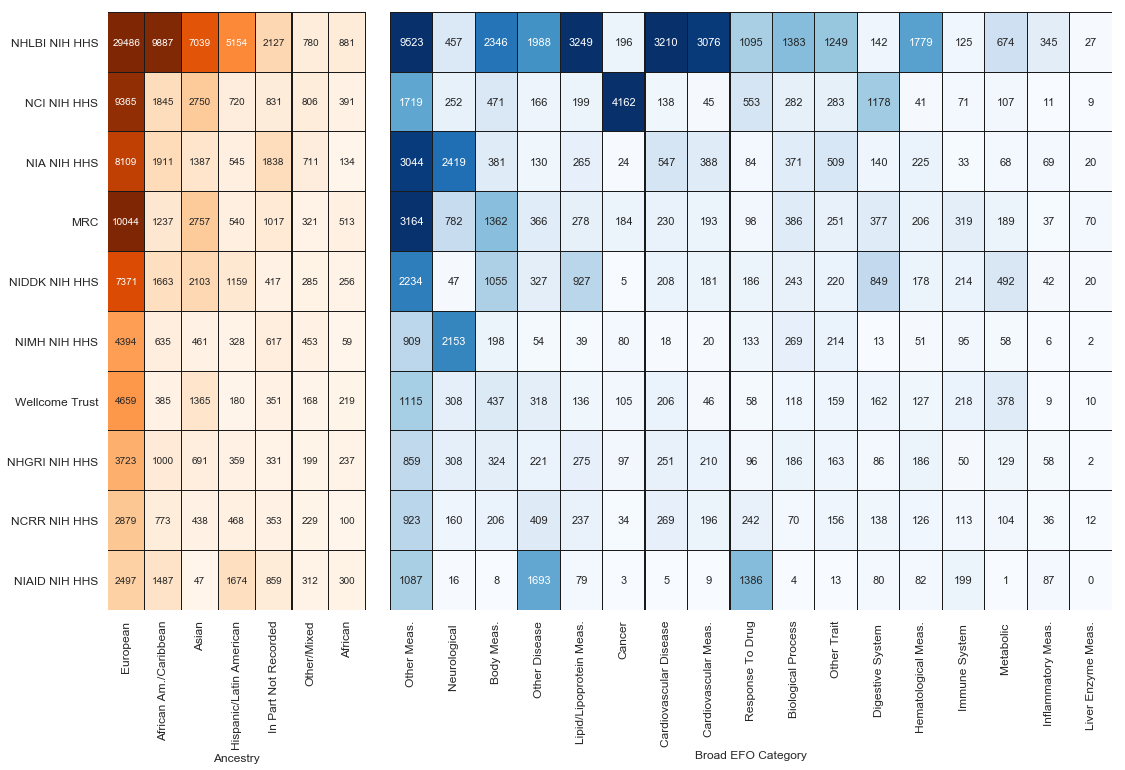

In [30]:
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
EFO_Parent_Mapped, EFO_Parent_Mapped_NoCommas = EFO_parent_mapper(
    Cat_Studies, Cat_Ancestry_groupedbyN)

EFO_Parent_Mapped['Parent term'] = \
    EFO_Parent_Mapped['Parent term'].str.replace('Disorder', '')

FunderInfo_Parent = pd.merge(FunderInfo, EFO_Parent_Mapped,
                             left_on='PUBMEDID', right_on='PUBMEDID',
                             how='left')

funder_ancestry, funder_parent = make_funders(FunderInfo_Parent, FunderInfo, Cat_Ancestry)
funder_parent.to_csv(os.path.abspath(os.path.join('__file__',
                                           '../..',
                                           'tables',
                                           'Funders_and_Ancestry.csv')))
funder_ancestry.to_csv(os.path.abspath(os.path.join('__file__',
                                           '../..',
                                           'tables',
                                           'Funders_and_BroadEFO.csv')))
output_path = os.path.abspath(os.path.join('__file__',
                                           '../..',
                                           'figures',
                                           'svg',
                                           'Figure_4.svg'))
plot_heatmap(funder_ancestry, funder_parent, output_path)

Lets do the same thing, but instead drop not split on the EFO commas:

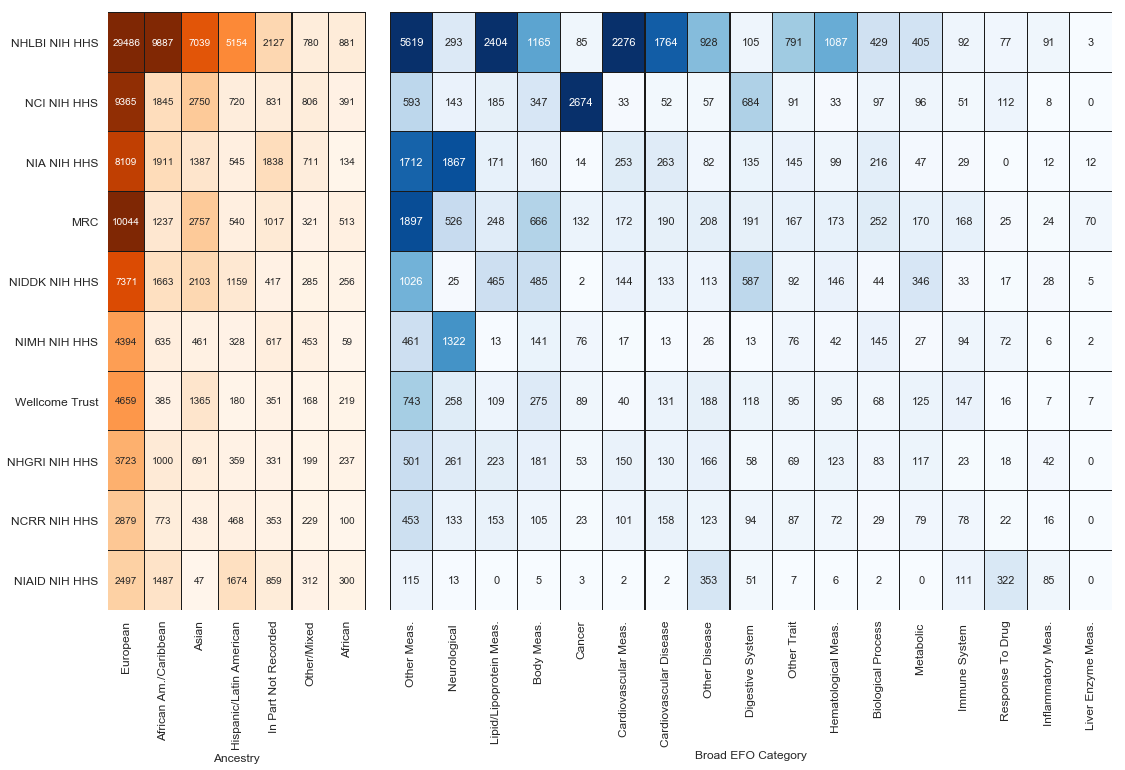

In [31]:
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
EFO_Parent_Mapped, EFO_Parent_Mapped_NoCommas = EFO_parent_mapper(
    Cat_Studies, Cat_Ancestry_groupedbyN)

EFO_Parent_Mapped_NoCommas['Parent term'] = \
    EFO_Parent_Mapped_NoCommas['Parent term'].str.replace('Disorder', '')

FunderInfo_Parent = pd.merge(FunderInfo, EFO_Parent_Mapped_NoCommas,
                             left_on='PUBMEDID', right_on='PUBMEDID',
                             how='left')

funder_ancestry, funder_parent = make_funders(FunderInfo_Parent, FunderInfo, Cat_Ancestry)
output_path = os.path.abspath(os.path.join('__file__', '../..', 'figures',
                                         'svg', 'Figure_4_NoCommas.svg'))
plot_heatmap(funder_ancestry, funder_parent, output_path)

# Who are the Authors?

Who are the most cited authors? What is their 'GWAS H-Index' calculated based only on their papers in the GWAS catalogue? This assumes unique forename + surname combinations, and that the same author is recorded consistently across studies. First a couple of snippets:

In [32]:
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()
print('There are a total of ' + str(len(AuthorMaster)) +
      ' "authorship contributions".')
print('These contributions are made by ' +
      str(len(AuthorMaster['AUTHORNAME'].unique())) + ' unique authors.')
print('There are a total of ' +
      str(len(AuthorMaster) /
          len(AuthorMaster['PUBMEDID'].drop_duplicates())) +
      ' "authorship contributions per paper".')
print('The study with the most number of authors has ' +
      str(AuthorMaster.groupby(['PUBMEDID']).size().max()) +
      ' authors (PubMed ID: ' +
      str(AuthorMaster.groupby(['PUBMEDID']).size().idxmax()) + ')')

There are a total of 119684 "authorship contributions".
These contributions are made by 39399 unique authors.
There are a total of 33.79949166902005 "authorship contributions per paper".
The study with the most number of authors has 559 authors (PubMed ID: 22479202)


## Calculate 'GWAS-H' indexes

Lets then calculate our GWAS-H indexes using citation data and paper counts for unique authors.

In [37]:
CitationCounts = pd.read_csv(os.path.abspath(
    os.path.join('__file__', "../..",
                 "data", "PUBMED", 'Pubmed_Cites.csv')))
AuthorMaster_withcites = pd.merge(
    AuthorMaster, CitationCounts, on=['PUBMEDID'], how='left')
allauthors_formerge = pd.DataFrame(
    AuthorMaster_withcites[['AUTHORNAME', 'citedByCount']])
allauthors_papercount = pd.DataFrame(
    allauthors_formerge['AUTHORNAME'].value_counts())
allauthors_citecount = pd.DataFrame(
    allauthors_formerge.groupby(by='AUTHORNAME')['citedByCount'].sum())
allauthors_merged = pd.merge(
    allauthors_papercount, allauthors_citecount, left_index=True,
    right_index=True)
allauthors_merged.columns = ['Papers', 'citedByCount']
allauthors_merged = allauthors_merged.sort_values(
    by='citedByCount', ascending=False)
allauthors_merged['GWAS-H'] = np.NaN
counter = 0
for author in allauthors_merged.index:
    counter += 1
    temp = AuthorMaster_withcites[AuthorMaster_withcites['AUTHORNAME'] ==
                                  author].sort_values(by='citedByCount',
                                                      ascending=False).dropna()
    temp = temp.reset_index()
    temp = temp.drop('index', 1)
    for pubnumber in range(0, len(temp)):
        if pubnumber + 1 >= temp['citedByCount'][pubnumber]:
            allauthors_merged.loc[author, ('GWAS-H')] = int(pubnumber)
            break
    sys.stdout.write('\r' + 'Calculating GWAS H-indices: finished ' +
                     str(counter) + ' of ' +
                     str(len(allauthors_merged.index)) + ' authors...')
allauthors_citecount.reset_index(inplace=True)
allauthors_papercount.reset_index(inplace=True)
allauthors_papercount.rename(
    columns={'AUTHORNAME': 'PAPERCOUNT', 'index': 'AUTHORNAME', },
    inplace=True)


Calculating GWAS H-indices: finished 39399 of 39399 authors...

In [38]:
allauthors_merged.head(5)

Papers  citedByCount  GWAS-H
Kari Stefansson            173         27034    83.0
Albert Hofman              263         24969    74.0
Unnur Thorsteinsdottir     138         23200    74.0
Andre G Uitterlinden       276         22781    74.0
Christian Gieger           164         22065    68.0

## Compare Author Metrics Between Genders

## Calculate author centralities

Lets next calculate some measures of authorship centrality with Network-X. Note: this can take some time on slow computers. To get it to run faster, change the CitedByCount to be something like 100 to filter for authors with a minimum of a hundred citations only (or change PAPERCOUNT>1)

In [39]:
AuthorMaster_sumcites = pd.merge(AuthorMaster, allauthors_citecount,
                                 left_on='AUTHORNAME', right_on='AUTHORNAME',
                                 how='left')
AuthorMaster_sumcitespapercount = pd.merge(AuthorMaster_sumcites,
                                           allauthors_papercount,
                                           left_on='AUTHORNAME',
                                           right_on='AUTHORNAME', how='left')
AuthorMaster_sumcitespapercount_filter_cites = AuthorMaster_sumcitespapercount[
    AuthorMaster_sumcitespapercount['citedByCount'] > 10]
AuthorMaster_sumcitespapercount_filtered =\
    AuthorMaster_sumcitespapercount_filter_cites[
        AuthorMaster_sumcitespapercount_filter_cites['PAPERCOUNT'] > 1]

G = nx.Graph()
counter = 0
alledges = []
for paper in AuthorMaster_sumcitespapercount_filtered['PUBMEDID'].unique():
    counter += 1
    temp = AuthorMaster_sumcitespapercount_filtered[
        AuthorMaster_sumcitespapercount_filtered['PUBMEDID'] == paper]
    if len(temp) > 1:
        templist = list(itertools.combinations(temp.AUTHORNAME, 2))
        for edge in templist:
            alledges.append(edge)
G.add_edges_from(list(set(alledges)))

print('This gives us a network with ' + str(len(G)) +
      ' nodes.\nThese are unique authors with >1 paper and >10 cites')

betcent = pd.Series(nx.betweenness_centrality(G), name='Betweenness')
allauthors_merged = allauthors_merged.merge(
    betcent.to_frame(), left_index=True, right_index=True)

degcent = pd.Series(nx.degree_centrality(G), name='Degree')
allauthors_merged = allauthors_merged.merge(
    degcent.to_frame(), left_index=True, right_index=True)

This gives us a network with 14903 nodes.
These are unique authors with >1 paper and >10 cites


KeyboardInterrupt: 

We can then merge all this data with some data collected manually from web searches related to their country of employment, their current employer, etc. We then rank in three different ways to analyze overlap between the three metrics.

In [ ]:
authorsupplemental = pd.read_csv(os.path.abspath(
    os.path.join('__file__', "../..",
                 "data", "Support", 'Author_Supplmentary.csv')),
     encoding='latin-1', index_col=0)
allauthors_merged_withsupp = pd.merge(allauthors_merged,
                                      authorsupplemental,
                                      left_index=True, right_index=True,
                                      how='left',)
allauthors_merged_withsupp['Betweenness'] = round(allauthors_merged_withsupp['Betweenness'],3)
allauthors_merged_withsupp['Degree'] = round(allauthors_merged_withsupp['Degree'],3)
allauthors_merged_withsupp['CitePercentile'] = round(allauthors_merged_withsupp.citedByCount.rank(pct=True),4)
allauthors_merged_withsupp['Papers','citedByCount',
                           'GWAS-H','Betweenness',
                           'Degree','Country',
                           'Institution',
                           'CitePercentile'].sort_values(by='GWAS-H',
                                                         ascending=False).to_csv(os.path.abspath(
                                                                                 os.path.join('__file__',
                                                                                              '../..',
                                                                                              'tables',
                                                                                              'Authors.csv')))
allauthors_merged_withsupp.sort_values(by='GWAS-H', ascending=False).head(20)

In [ ]:
allauthors_merged_withsupp.sort_values(by='Degree',ascending=False).head(10)

In [ ]:
allauthors_merged_withsupp.sort_values(by='citedByCount',
                                       ascending=False).head(10)

And then make a simple correlation matrix to check how highly related these metrics are:

In [ ]:
allauthors_merged_withsupp[['citedByCount', 'GWAS-H',
                            'Betweenness', 'Degree', 'Papers']].corr()

In [ ]:
print('There are a total of ' +
      str(len(allauthors_merged_withsupp)) + ' authors in the table.')
print('The person with the highest G-WAS H-Index is: ' +
      allauthors_merged_withsupp['GWAS-H'].idxmax())
print('The person with the highest Degree is: ' +
      allauthors_merged_withsupp['Degree'].idxmax())
print('The person with the highest citedByCount is: ' +
      allauthors_merged_withsupp['citedByCount'].idxmax())
print('The person with the most number of Papers is: ' +
      allauthors_merged_withsupp['Papers'].idxmax())

## Author gender

Lets consider the gender of each author by analyzing their forenames using the genderguesser library. We can directly compare our results to [this wonderful paper](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0066212). One of the key assumptions made here is to combine all 'mostly_' male and female names into their respective male/female categories.

In [ ]:
gendet = gender.Detector()
FunderInfo, AbstractInfo, AuthorMaster = load_pubmed_data()
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()

AuthorCounts = AuthorMaster.groupby(['PUBMEDID'])['AUTHORNAME'].count(
).to_frame().reset_index().rename(columns={"AUTHORNAME": "Author Count"})
AuthorMaster = pd.merge(AuthorMaster, AuthorCounts, how='left', on='PUBMEDID')
AuthorMaster['CleanForename'] = AuthorMaster['FORENAME'].map(
    lambda x: clean_names(x))
AuthorMaster['CleanGender'] = AuthorMaster['CleanForename'].map(
    lambda x: gendet.get_gender(x))
AuthorMaster['MaleFemale'] = AuthorMaster['CleanGender'].str.replace('mostly_',
                                                                     '')
AuthorMaster['isfemale'] = np.where(
    AuthorMaster['MaleFemale'] == 'female', 1, 0)
AuthorFirst = AuthorMaster[AuthorMaster['Author Count']
                           > 4].drop_duplicates(subset='PUBMEDID', keep='first')
AuthorLast = AuthorMaster[AuthorMaster['Author Count']
                          > 4].drop_duplicates(subset='PUBMEDID', keep='last')
AuthorUnique = AuthorMaster.drop_duplicates(subset='AUTHORNAME')

for gender_ in AuthorMaster['CleanGender'].unique():
    print(str(round((len(AuthorMaster[AuthorMaster['CleanGender'] == gender_]) /
                     len(AuthorMaster['CleanGender'])) * 100, 2)) + '%' +
          ' ' + gender_ + ' authorship contributions in total')
    print(str(round((len(AuthorUnique[AuthorUnique['CleanGender'] == gender_]) /
                     len(AuthorUnique['CleanGender'])) * 100, 2)) + '%' +
          ' ' + gender_ + ' authors contributions in total')
    print(str(round((len(AuthorFirst[AuthorFirst['CleanGender'] == gender_]) /
                     len(AuthorFirst['CleanGender'])) * 100, 2)) + '%' +
          ' ' + gender_ + ' first authors in total')
    print(str(round((len(AuthorLast[AuthorLast['CleanGender'] == gender_]) /
                     len(AuthorFirst['CleanGender'])) * 100, 2)) + '%' +
          ' ' + gender_ + ' last authors in total')

print('\nPercent of male author contributions: ' +
      str(round(len(AuthorMaster[AuthorMaster['MaleFemale'] == 'male']) /
                (len(AuthorMaster[(AuthorMaster['MaleFemale'] == 'male') |
                                  (AuthorMaster['MaleFemale'] == 'female')])) *
                100, 3)) + '%')

print('Percent of unique male authors: ' +
      str(round(len(AuthorUnique[AuthorUnique['MaleFemale'] == 'male']) /
                (len(AuthorUnique[(AuthorUnique['MaleFemale'] == 'male') |
                                  (AuthorUnique['MaleFemale'] == 'female')])) *
                100, 3)) + '%')

print('Percent of male first authors: ' +
      str(round(len(AuthorFirst[AuthorFirst['MaleFemale'] == 'male']) /
                (len(AuthorFirst[(AuthorFirst['MaleFemale'] == 'male') |
                                 (AuthorFirst['MaleFemale'] == 'female')])) *
                100, 3)) + '%')

print('Percent of male last authors: ' +
      str(round(len(AuthorLast[AuthorLast['MaleFemale'] == 'male']) /
                (len(AuthorLast[(AuthorLast['MaleFemale'] == 'male') |
                                (AuthorLast['MaleFemale'] == 'female')])) *
                100, 3)) + '%')

AuthorMaster_filtered = AuthorMaster[(AuthorMaster['MaleFemale'].str.contains(
    'male')) & (AuthorMaster['Author Count'] > 4)]
AuthorMaster_filtered_merged_bydisease = pd.merge(
    AuthorMaster_filtered, Cat_Studies[['PUBMEDID', 'DISEASE/TRAIT']],
    how='left', on='PUBMEDID')

meanfemales_bydisease = AuthorMaster_filtered_merged_bydisease.groupby(
    ['DISEASE/TRAIT'])['isfemale'].mean().to_frame()
numberofstudies_bydisease = Cat_Studies.groupby(
    ['DISEASE/TRAIT'])['DISEASE/TRAIT'].count().to_frame()
mergedgender_andcount_bydisease = pd.merge(
    numberofstudies_bydisease, meanfemales_bydisease, left_index=True,
    right_index=True)
mergedgender_andcount_bydisease = mergedgender_andcount_bydisease.sort_values(
    by='DISEASE/TRAIT', ascending=False)[0:10]
holdstring = 'Percent of authorships across 10 most commonly studied diseases:\n'
for index, row in mergedgender_andcount_bydisease.iterrows():
    holdstring = holdstring + \
        index.title() + ' (' + str(round(row['isfemale'], 3) * 100) + '%)\n'
print('\n' + holdstring[:-1])

In [ ]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
EFO_Parent_Mapped, EFO_Parent_Mapped_NoCommas = EFO_parent_mapper(
    Cat_Studies, Cat_Ancestry_groupedbyN)

ranks, countstudiesperEFO, meanfemale, AuthorMaster_EFO, AuthorMaster_Parent = make_meanfemale_andranks(AuthorMaster,
                                                                                    EFO_Parent_Mapped)
output_path = os.path.abspath(os.path.join('__file__', "../..", "figures",
                                           'svg', 'Sup_Figure_1_Commas.svg'))
boxswarm_plot(meanfemale, ranks, output_path)

AuthorMaster_Parent.reset_index(inplace=True)
holdstring = 'Get the numbers for Parent Terms:\n'
for index, row in AuthorMaster_Parent.iterrows():
    holdstring = holdstring + row['Parent term'].title() + ' (' \
        + str(round(row['isfemale'], 3) * 100) + '%)\n'
print('\n' + holdstring[:-2])
holdstring = 'Get the numbers for Trait Terms (figure above):\n'
for index, row in AuthorMaster_EFO[
    AuthorMaster_EFO['EFO term'].isin(countstudiesperEFO)].sort_values(
        by='isfemale', ascending=False).iterrows():
    holdstring = holdstring + \
        row['EFO term'].title() + ' (' + str(round(row['isfemale'], 3) *
                                             100) + '%)\n'
print('\n' + holdstring[:-1])

Lets do exactly the same thing as above, but drop the fields with commas in:

In [ ]:
ranks, countstudiesperEFO, meanfemale, AuthorMaster_EFO, AuthorMaster_Parent = make_meanfemale_andranks(AuthorMaster, EFO_Parent_Mapped_NoCommas)
output_path = os.path.abspath(os.path.join('__file__', "../..", "figures",
                                           'svg', 'Sup_Figure_1_NoCommas.svg'))
boxswarm_plot(meanfemale, ranks, output_path)

AuthorMaster_Parent.reset_index(inplace=True)
holdstring = 'Get the numbers for Parent Terms:\n'
for index, row in AuthorMaster_Parent.iterrows():
    holdstring = holdstring + row['Parent term'].title() + ' (' \
        + str(round(row['isfemale'], 3) * 100) + '%)\n'
print('\n' + holdstring[:-2])
holdstring = 'Get the numbers for Trait Terms (figure above):\n'
for index, row in AuthorMaster_EFO[
    AuthorMaster_EFO['EFO term'].isin(countstudiesperEFO)].sort_values(
        by='isfemale', ascending=False).iterrows():
    holdstring = holdstring + \
        row['EFO term'].title() + ' (' + str(round(row['isfemale'], 3) *
                                             100) + '%)\n'
print('\n' + holdstring[:-1])

## Compare Author Metrics Between Genders

In [ ]:
allauthors_merged_reset = allauthors_merged.reset_index().rename(columns={'index': 'Name'})
allauthors_merged_reset['CleanForename'] = allauthors_merged_reset['Name'].map(lambda x: x.split(' ')[0]) 
allauthors_merged_reset['CleanGender'] = allauthors_merged_reset['CleanForename'].map(
    lambda x: gendet.get_gender(x))
allauthors_merged_reset['MaleFemale'] = allauthors_merged_reset['CleanGender'].str.replace('mostly_',
                                                                     '')
allauthors_merged_reset['isfemale'] = np.where(
   allauthors_merged_reset['MaleFemale'] == 'female', 1, 0)

print('The average GWAS-H Index for females is: ' +
      str(round(allauthors_merged_reset[allauthors_merged_reset['MaleFemale']=='female']['GWAS-H'].mean(),3)))
print('The average GWAS-H Index for males is: ' +
      str(round(allauthors_merged_reset[allauthors_merged_reset['MaleFemale']=='male']['GWAS-H'].mean(),3)))
print('The average number of papers published by females is: ' +
      str(round(allauthors_merged_reset[allauthors_merged_reset['MaleFemale']=='female']['Papers'].mean(),3)))
print('The average number of papers published by males is: ' +
     str(round(allauthors_merged_reset[allauthors_merged_reset['MaleFemale']=='male']['Papers'].mean(),3)))
print('The average number of citations for females is: ' +
      str(round(allauthors_merged_reset[allauthors_merged_reset['MaleFemale']=='female']['citedByCount'].mean(),3)))
print('The average number of citations for males is: ' +
      str(round(allauthors_merged_reset[allauthors_merged_reset['MaleFemale']=='male']['citedByCount'].mean(),3)))

# Cohorts and Consortium

## Consortium/collectives

Lets use the PubMed database returns on collectives to analyze which consortium and study groups are acknowledged:

In [ ]:
pubmed_collectives = pd.read_csv(os.path.abspath(
                                 os.path.join('__file__', '../..',
                                              'data', 'PUBMED',
                                              'Pubmed_CollectiveInfo.csv')),
                                 encoding='latin-1')
collect_dict = pd.read_csv(os.path.abspath(
                           os.path.join(
                               '__file__', '../..', 'data',
                               'Support', 'Collectives',
                               'Collective_Dictionary.csv')),
                           encoding='latin-1')
pubmed_collectives['COLLECTIVE'] = pubmed_collectives['COLLECTIVE'].str.strip()
pubmed_collectives['COLLECTIVE'] = pubmed_collectives['COLLECTIVE'].str.lower()
collect_dict['COLLECTIVE'] = collect_dict['COLLECTIVE'].str.strip(
).str.lower()
merged_collect = pd.merge(
    pubmed_collectives, collect_dict, how='left', on='COLLECTIVE')
if len(merged_collect[merged_collect['Clean_Name'].isnull()]) > 0:
    print('Danger! Correct collectives in Collective_Unverified.csv ' +
          'and add to the dictionary\n')
    unverified_collect = merged_collect[merged_collect['Clean_Name'].isnull(
    )]
    unverified_collect.to_csv(os.path.abspath(
                              os.path.join('__file__', '../..',
                                           'data', 'Support', 'Collectives',
                                           'Collective_Unverified.csv')), encoding='latin-1')
else:
    print('The consortium dictionary is up to date!\n')
consortiumlist = []
for index, row in merged_collect.iterrows():
    if pd.isnull(row['Clean_Name']) is False:
        for consortium in row['Clean_Name'].split(';'):
            consortiumlist.append(consortium)
clean_collectives = pd.DataFrame(consortiumlist, columns=['Consortium'])
groupby_collectives = clean_collectives.groupby(
    ['Consortium'])['Consortium'].count().sort_values(ascending=False)
holdstring = 'The most frequently seen Consortium are:\n'
for index, row in groupby_collectives.to_frame()[0:10].iterrows():
    holdstring = holdstring + index + ' (' + str(row['Consortium']) + ')\n'
print(holdstring[:-2] + ')')

print('\nWe have seen a total of ' +
      str(len(groupby_collectives.to_frame())) + ' different collectives!')
print('A total of ' + str(len(pubmed_collectives['PUBMEDID'].drop_duplicates(
))) + ' papers are contributed to by at least one collective.')
print('A total of ' + str(groupby_collectives.sum()) +
      ' collective contributions are made.')

## Datasets

Lets now simply wrangle together some of the manually collated data and consider the most frequently observed cohorts, with the aim being to analyze the resampling issue discussed earlier in the literature.

In [152]:
finaldataset = pd.read_csv(os.path.abspath(
    os.path.join('__file__', '../..', 'data',
                 'Support', 'Cohorts',
                 'manually_parsed_data.csv')),
    encoding='latin-1')
mylist = []
for index, row in finaldataset.iterrows():
    mylist = mylist + row['DATASETS'].split(';')
mylist = [x.strip().upper() for x in mylist]
df1 = pd.DataFrame({'Cohorts': mylist})
reader = csv.reader(open(os.path.abspath(os.path.join(
    '__file__', '../..', 'data', 'Support', 'Cohorts',
    'Dictionary_cohorts.csv')), 'r'))
d = {}
for row in reader:
    k, v = row
    d[k] = v
for key in d:
    df1['Cohorts'].replace(key, d[key], inplace=True)
df1['Cohorts'] = df1['Cohorts'].str.replace(
    'Rotterdam Study I (RS-I)', 'Rotterdam Study (RS)')
df1['Cohorts'].replace('&', 'and', inplace=True)
df1['Cohorts'] = df1['Cohorts'].str.upper()
newdf = pd.DataFrame(df1.groupby(['Cohorts'])[
                     'Cohorts'].count(), columns=['Count'])
newdf = pd.DataFrame({'Count': df1.groupby(['Cohorts']).size()}).reset_index()

Then merge this with manually collated data:

In [153]:
manual_cohort_for_merge = pd.read_csv(os.path.abspath(
    os.path.join('__file__', "../..", "data",
                 "Support", "Cohorts",
                 "manual_cohort_for_merge.csv")),
    encoding='latin-1', index_col=False)
merged_manual = pd.merge(newdf, manual_cohort_for_merge,
                         how='left', on='Cohorts')
merged_manual.set_index('Cohorts').sort_values(
    by='Count', ascending=False).drop('NO NAME').head(10).style

Lets now print out a list of the 50 most commonly used datasets in case we need to reference any specific particularily prominent ones (e.g. deCODE, UKBioBank etc):

In [154]:
merged_manual=merged_manual.set_index('Cohorts').sort_values(by='Count', ascending=False)
holder='The 30 most commonly used datasets are:\n\n'
for index, row in merged_manual[0:30].iterrows():
    holder = holder + \
        str(index) + ' (' + str(row['Count']) + ' times)\n'
print(holder[:-2])
merged_manual[['Count']].to_csv(os.path.abspath(
                                os.path.join('__file__',
                                             '../..',
                                             'data',
                                             'Support',
                                             'Cohorts',
                                             'Cohort_Count.csv')), encoding='latin-1')

The 30 most commonly used datasets are:

ROTTERDAM STUDY (RS) (398 times)
NO NAME (297 times)
COOPERATIVE HEALTH RESEARCH IN THE REGION OF AUGSBURG (KORA) (255 times)
FRAMINGHAM HEART STUDY (FHS) (207 times)
ATHEROSCLEROSIS RISK IN COMMUNITIES STUDY (ARIC) (204 times)
CARDIOVASCULAR HEALTH STUDY (CHS) (179 times)
BRITISH 1958 BIRTH COHORT STUDY (B58C) (156 times)
UK ADULT TWIN REGISTER (TWINSUK) (140 times)
EUROPEAN PROSPECTIVE INVESTIGATION INTO CANCER (EPIC) (132 times)
NURSES HEALTH STUDY (NHS) (129 times)
STUDY OF HEALTH IN POMERANIA (SHIP) (127 times)
AGING GENE-ENVIRONMENT SUSCEPTIBILITY - REYKJAVIK STUDY (AGES) (119 times)
DECODE GENETICS (DECODE) (113 times)
ERASMUS RUCPHEN FAMILY STUDY (ERF) (104 times)
WELLCOME TRUST CASE CONTROL CONSORTIUM (WTCCC) (103 times)
MULTI-ETHNIC STUDY OF ATHEROSCLEROSIS (MESA) (98 times)
HEALTH, AGING, AND BODY COMPOSITION STUDY (HEALTH ABC) (92 times)
NORTHERN FINNISH BIRTH COHORT STUDY (NFBC) (87 times)
NETHERLANDS TWIN REGISTRY (NTR) (78 times)


In [155]:
Cat_Studies, Cat_Ancestry, Cat_Ancestry_groupedbyN, Cat_Full = load_gwas_cat()
PUBMED_by_N = pd.DataFrame(Cat_Ancestry.groupby(['PUBMEDID'])['N'].agg('sum').sort_values(ascending=False))
merged_raw_and_manual = pd.merge(PUBMED_by_N.reset_index(), finaldataset, left_on='PUBMEDID',
                                 right_on='PUBMEDID', how='left')
print('We have counted ' + str(len(df1['Cohorts'])) + ' (non-unique) cohorts in total')
print('We have counted ' + str(len(newdf)) + ' unique cohorts in total.')
print("We're currently missing " +
      str(len(set(PUBMED_by_N[0:1000].index)-set(finaldataset['PUBMEDID']))) + 
     " of the biggest 1000 papers grouped by summed ancestry!")
print('We currently have coverage for ' + 
      str(round((merged_raw_and_manual[merged_raw_and_manual['In Charge'].notnull()]['N'].sum()/
          PUBMED_by_N['N'].sum())*100,2)) +
      '% of all papers by N.')
print('We currently have coverage for ' + 
      str(round((len(finaldataset)/len(PUBMED_by_N))*100,2)) +
      '% of all papers in absolute.')
merged_raw_and_manual.to_csv(os.path.abspath(
                             os.path.join('__file__',
                                          '../..',
                                          'data',
                                          'Support',
                                          'Cohorts',
                                          'Merged_Cohorts_Manual_Curation.csv')), encoding='latin-1')
merged_raw_and_manual[~merged_raw_and_manual['In Charge'].notnull()]['PUBMEDID'].to_csv(os.path.abspath(
                                                                            os.path.join('__file__',
                                                                                         '../..',
                                                                                         'data',
                                                                                         'Support',
                                                                                         'Cohorts',
                                                                                         'Outstanding_PUBMEDIDs_To_Curate.csv')),encoding='latin-1')

We have counted 11851 (non-unique) cohorts in total
We have counted 2001 unique cohorts in total.
We're currently missing 38 of the biggest 1000 papers grouped by summed ancestry!
We currently have coverage for 87.76% of all papers by N.
We currently have coverage for 34.84% of all papers in absolute.


In [151]:
#need to make the above pep8